In [24]:
import sys
sys.path.append('..')

# Enable autoreload of modules
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from hardwares.hardware_params import hardware_params
from model_analyzer import ModelAnalyzer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Initialize model analyzer
model_id = "meta-llama/Llama-2-7b-hf"
hardware = "nvidia_A100"
analyzer = ModelAnalyzer(model_id, hardware)

use config file configs/Llama.py for meta-llama/Llama-2-7b-hf


## 1. Operator Breakdown Analysis
This section visualizes the breakdown of different operators in terms of computation time and memory usage.

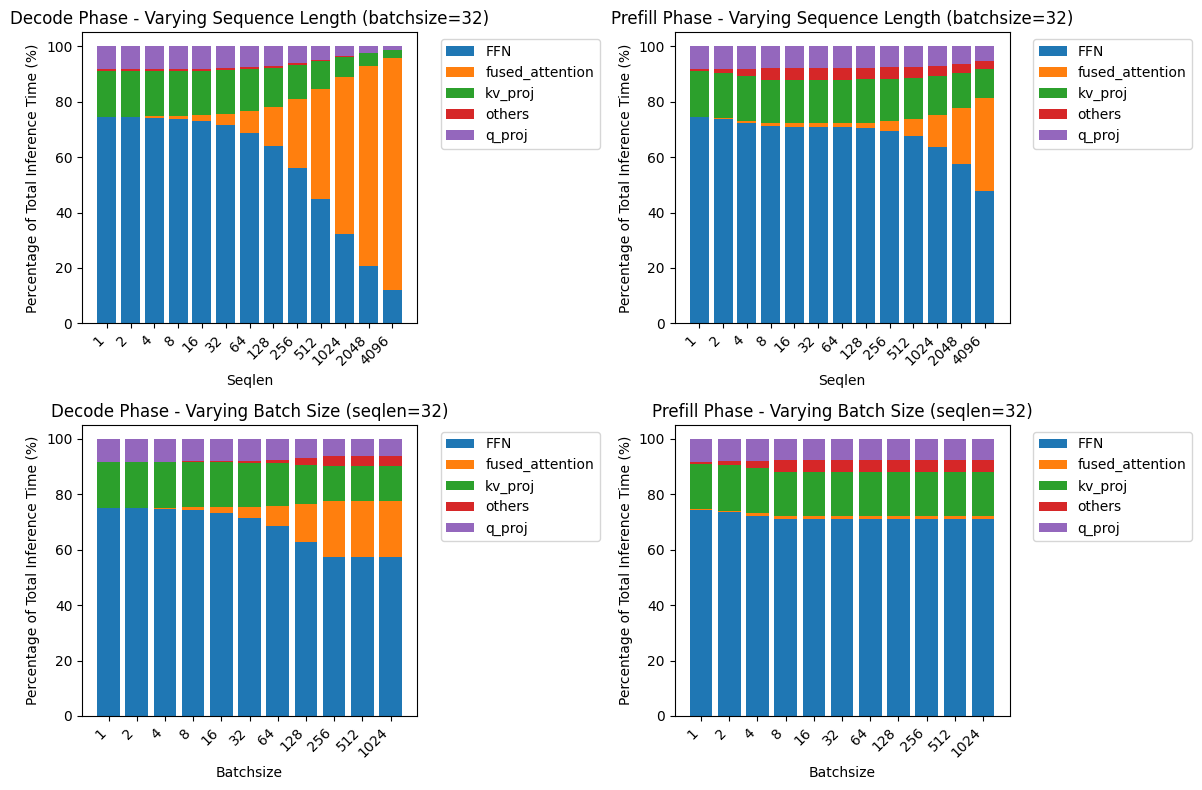

In [6]:
def get_operator_breakdown(configs, use_ratio=True):
    all_operators = set()
    config_data = []
    for config in configs:
        result = analyzer.analyze(
            config["seqlen"], 
            config["batchsize"], 
            use_flashattention=True
        )
        phase_data = result[config["phase"]]
        total_time = sum(phase_data[op]["inference_time"] for op in phase_data if op != "lm_head")
        operator_times = {}
        others_time = 0
        kv_time = 0
        ffn_time = 0
        for op, data in phase_data.items():
            if op == "lm_head":
                continue
            elif op.endswith(("_norm", "_act", "_add")):
                others_time += data["inference_time"]
            elif op in ["k_proj", "v_proj"]:
                kv_time += data["inference_time"]
            elif op in ["out_proj", "gate_proj", "up_proj", "down_proj"]:
                ffn_time += data["inference_time"]
            elif op == "q_proj":
                operator_times["q_proj"] = (data["inference_time"] / total_time) * 100 if use_ratio else data["inference_time"]
            elif op == "fused_attention":
                operator_times["fused_attention"] = (data["inference_time"] / total_time) * 100 if use_ratio else data["inference_time"]
        if kv_time > 0:
            operator_times["kv_proj"] = (kv_time / total_time) * 100 if use_ratio else kv_time
        if ffn_time > 0:
            operator_times["FFN"] = (ffn_time / total_time) * 100 if use_ratio else ffn_time
        if others_time > 0:
            operator_times["others"] = (others_time / total_time) * 100 if use_ratio else others_time
        all_operators.update(operator_times.keys())
        config_data.append(operator_times)
    return all_operators, config_data

def plot_stacked_bar(ax, configs, title, x_axis_label, use_ratio=True):
    all_operators, config_data = get_operator_breakdown(configs, use_ratio)
    operators = sorted(list(all_operators))
    x_labels = [str(c[x_axis_label]) for c in configs]
    # Prepare data for each operator
    data_matrix = []
    for operator in operators:
        data_matrix.append([d.get(operator, 0) for d in config_data])
    data_matrix = np.array(data_matrix)
    # Plot
    bottom = np.zeros(len(configs))
    for i, operator in enumerate(operators):
        ax.bar(x_labels, data_matrix[i], bottom=bottom, label=operator)
        bottom += data_matrix[i]
    ax.set_ylabel('Percentage of Total Inference Time (%)')
    ax.set_xlabel(x_axis_label.capitalize())
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')


def plot_operator_breakdown(seqlen, batchsize, use_ratio=True):
    seqlens = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
    batchsizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    
    # Now plot each subplot
    decode_seqlen_configs = [{"seqlen": s, "batchsize": 32, "phase": "decode"} for s in seqlens]
    plot_stacked_bar(ax1, decode_seqlen_configs, "Decode Phase - Varying Sequence Length (batchsize=32)", "seqlen", use_ratio)

    prefill_seqlen_configs = [{"seqlen": s, "batchsize": 32, "phase": "prefill"} for s in seqlens]
    plot_stacked_bar(ax2, prefill_seqlen_configs, "Prefill Phase - Varying Sequence Length (batchsize=32)", "seqlen", use_ratio)

    decode_batchsize_configs = [{"seqlen": 32, "batchsize": b, "phase": "decode"} for b in batchsizes]
    plot_stacked_bar(ax3, decode_batchsize_configs, "Decode Phase - Varying Batch Size (seqlen=32)", "batchsize", use_ratio)

    prefill_batchsize_configs = [{"seqlen": 32, "batchsize": b, "phase": "prefill"} for b in batchsizes]
    plot_stacked_bar(ax4, prefill_batchsize_configs, "Prefill Phase - Varying Batch Size (seqlen=32)", "batchsize", use_ratio)

    plt.tight_layout()
    return fig

# Example usage
fig = plot_operator_breakdown(seqlen=1024, batchsize=1)
plt.show()

### Here, as "batchsize" tokens are processed, time increases with batchsize and decreases with seqlen
But this cannot explain that SRF is better... because LRF should be better (avoiding decoding short requests??)
Or, SRF stabilizes cache utilization... not adding many KVs every batch

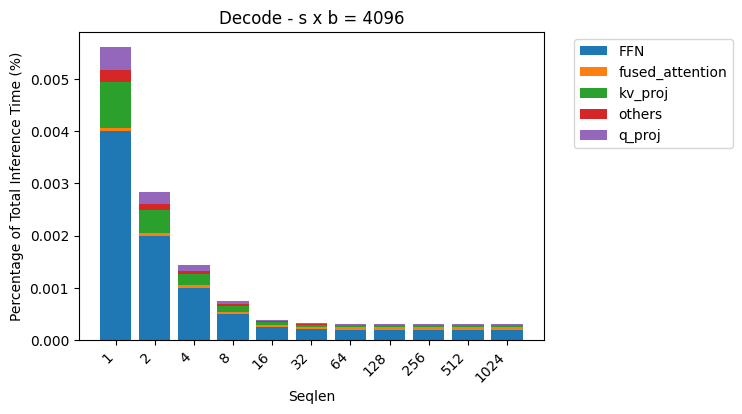

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
seqlens = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
configs = [{"seqlen": s, "batchsize": int(4096 / s), "phase": "decode"} for s in seqlens]
plot_stacked_bar(ax, configs, "Decode - s x b = 4096", "seqlen", use_ratio=False)
plt.show()

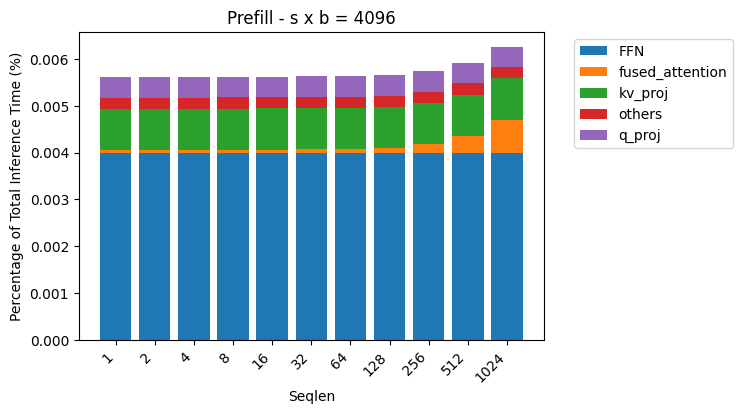

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
seqlens = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
configs = [{"seqlen": s, "batchsize": int(4096 / s), "phase": "prefill"} for s in seqlens]
plot_stacked_bar(ax, configs, "Prefill - s x b = 4096", "seqlen", use_ratio=False)
plt.show()

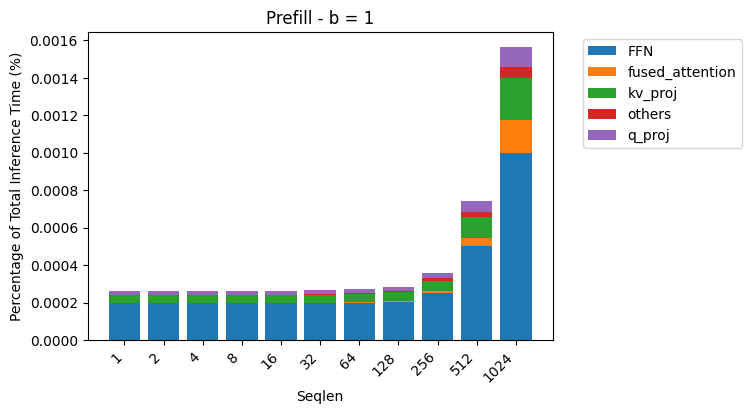

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
seqlens = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
configs = [{"seqlen": s, "batchsize": 1, "phase": "prefill"} for s in seqlens]
plot_stacked_bar(ax, configs, "Prefill - b = 1", "seqlen", use_ratio=False)
plt.show()

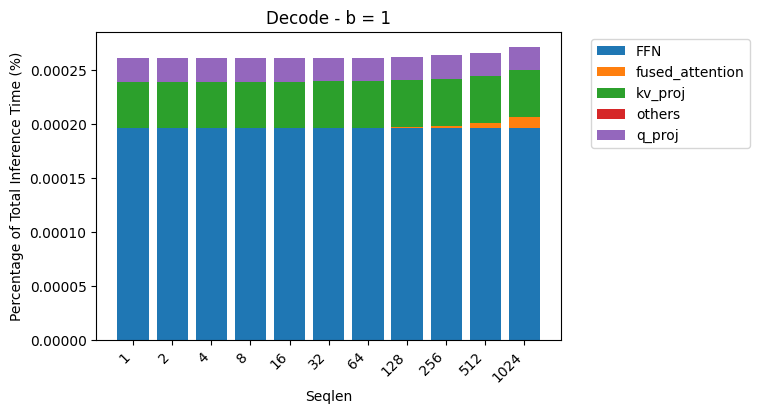

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
seqlens = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
configs = [{"seqlen": s, "batchsize": 1, "phase": "decode"} for s in seqlens]
plot_stacked_bar(ax, configs, "Decode - b = 1", "seqlen", use_ratio=False)
plt.show()

## 2. Roofline Model Analysis
This section visualizes the roofline model showing the relationship between computational intensity and performance.

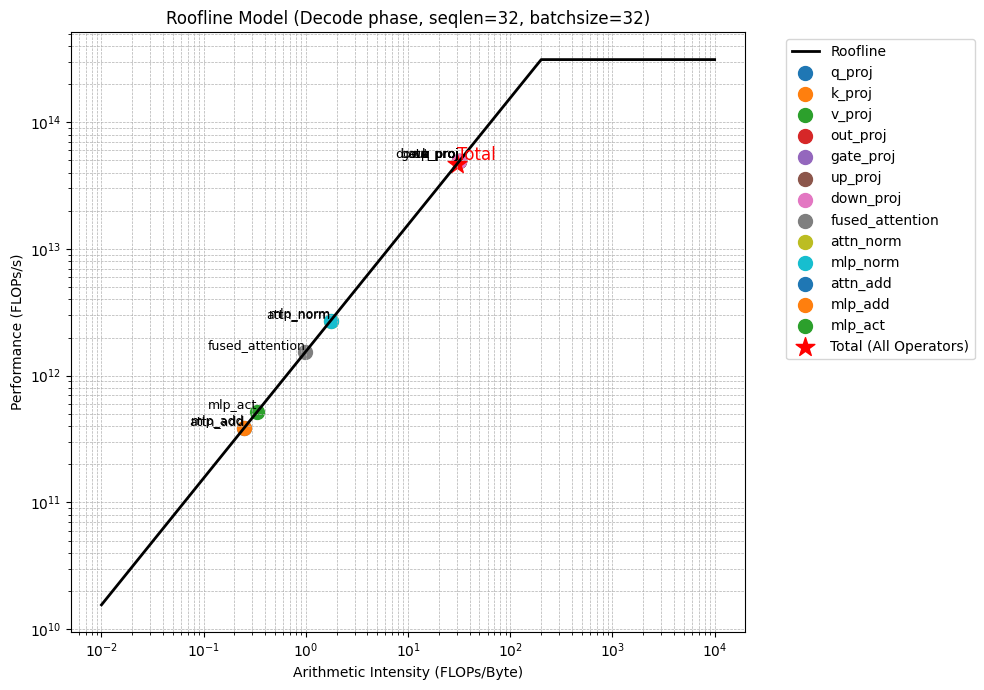

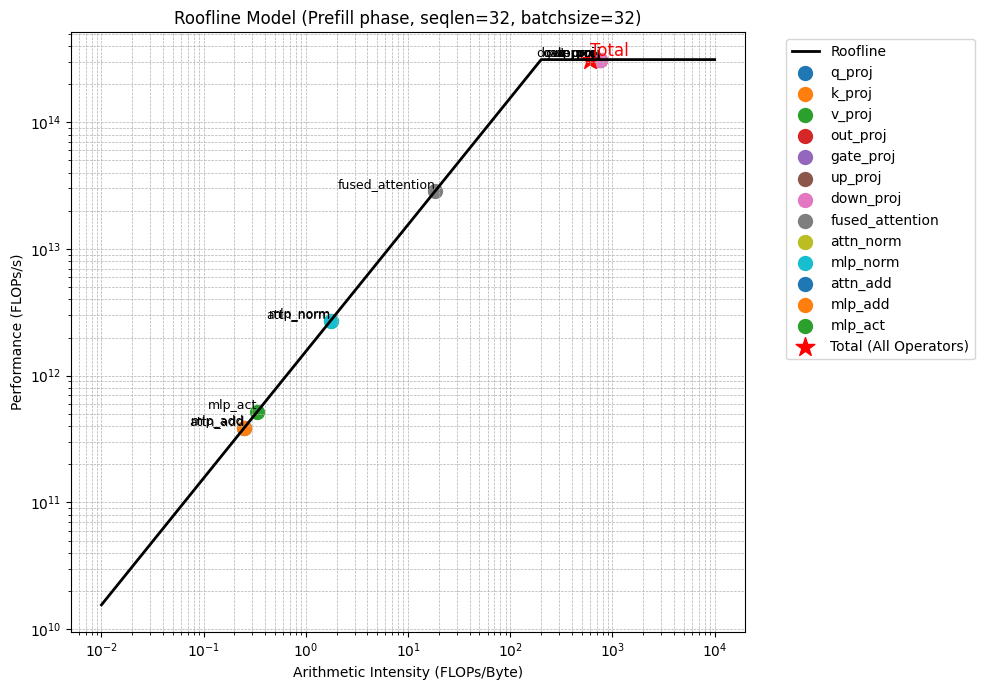

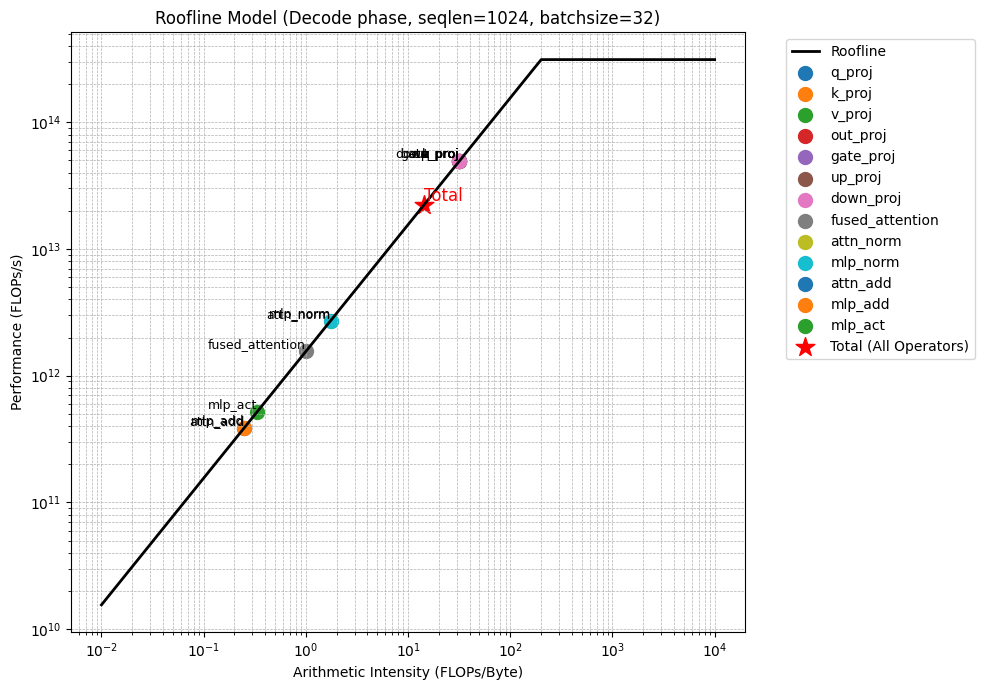

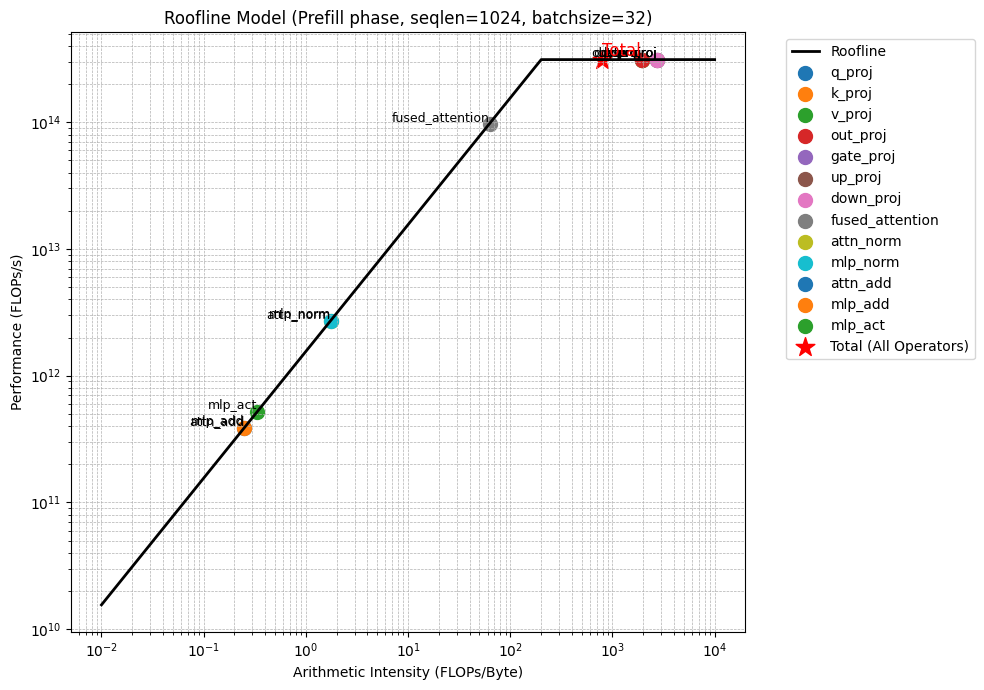

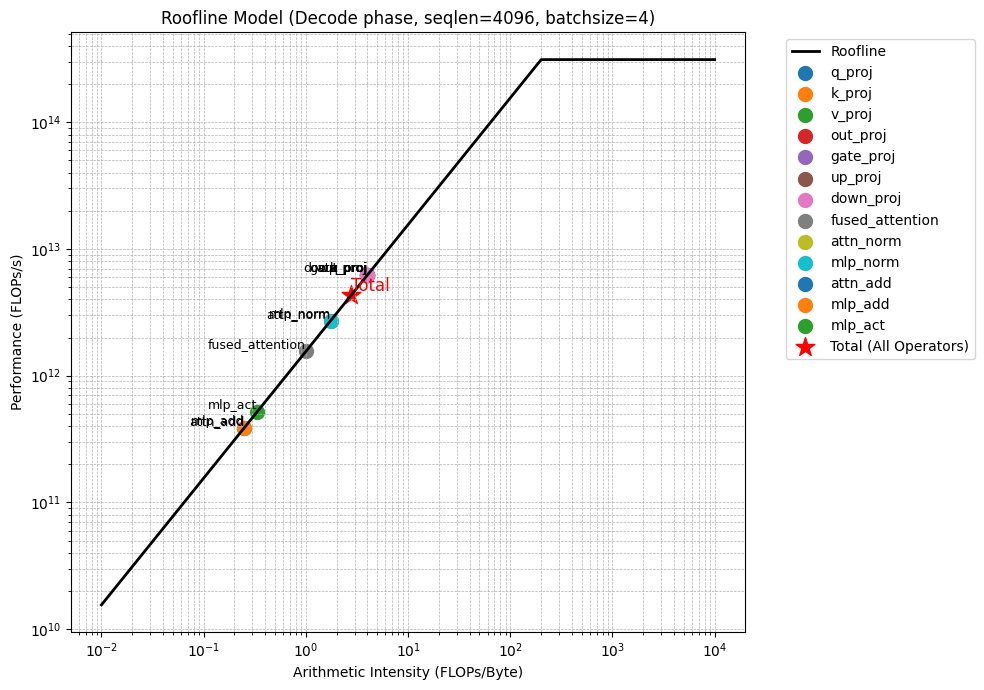

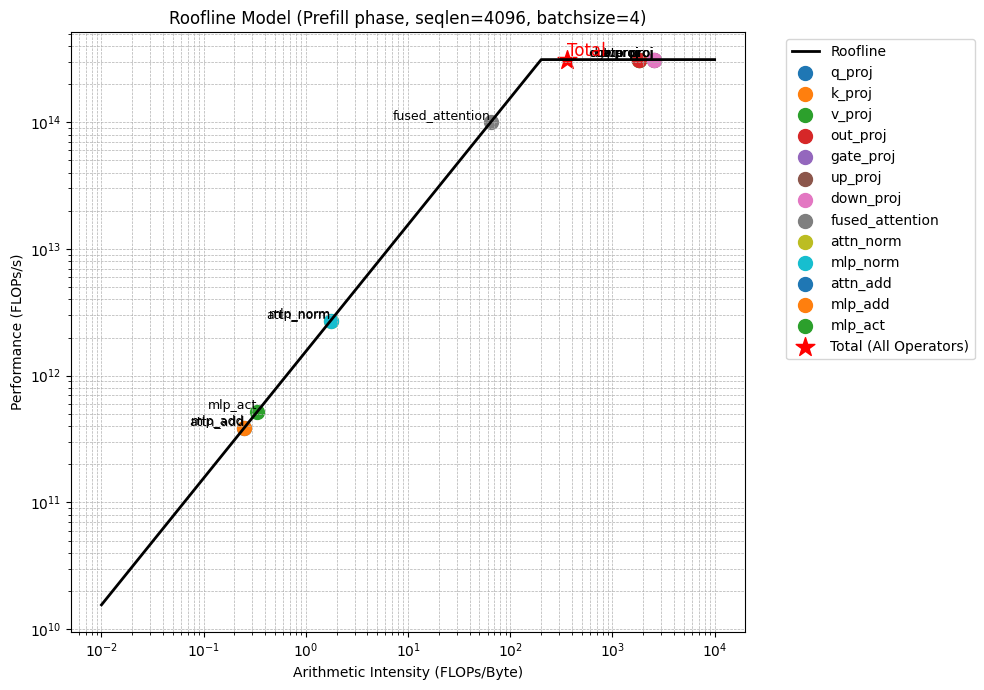

In [50]:
def plot_roofline_per_operator(analyzer, seqlen, batchsize, phase="decode"):
    """
    Plot the roofline model for all operators individually (no merging).
    Also plot a point for the total (all operators combined).
    The hardware is inferred from the analyzer instance.
    """
    # Get hardware roofline
    hardware_name = analyzer.hardware
    from hardwares.hardware_params import hardware_params
    bandwidth = hardware_params[hardware_name]["bandwidth"]
    max_ops = hardware_params[hardware_name]["FP16"]  # or "INT8" if using int8
    ai_range = np.logspace(-2, 4, 100)
    roofline = np.minimum(max_ops, ai_range * bandwidth)

    # Get analysis result
    result = analyzer.analyze(seqlen, batchsize, use_flashattention=True)
    phase_data = result[phase]

    # Plot roofline
    plt.figure(figsize=(10, 7))
    plt.plot(ai_range, roofline, label="Roofline", color="black", linewidth=2)

    # Plot each operator as a point
    for op_name, op_data in phase_data.items():
        if op_name == "lm_head":
            continue  # skip lm_head if not wanted
        ai = op_data["arithmetic_intensity"]
        perf = op_data["performance"]
        plt.scatter(ai, perf, label=op_name, s=100)
        plt.text(ai, perf, op_name, fontsize=9, ha='right', va='bottom')

    # Plot total point (all operators combined)
    total_ops = result["total_results"][phase]["OPs"]
    total_mem = result["total_results"][phase]["memory_access"]
    if total_mem > 0:
        total_ai = total_ops / total_mem
    else:
        total_ai = 0
    total_perf = min(max_ops, total_ai * bandwidth)
    plt.scatter(total_ai, total_perf, color="red", s=200, marker="*", label="Total (All Operators)")
    plt.text(total_ai, total_perf, "Total", fontsize=12, ha='left', va='bottom', color="red")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Arithmetic Intensity (FLOPs/Byte)")
    plt.ylabel("Performance (FLOPs/s)")
    plt.title(f"Roofline Model ({phase.capitalize()} phase, seqlen={seqlen}, batchsize={batchsize})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_roofline_per_operator(analyzer, seqlen=32, batchsize=32, phase="decode")
plot_roofline_per_operator(analyzer, seqlen=32, batchsize=32, phase="prefill")
plot_roofline_per_operator(analyzer, seqlen=1024, batchsize=32, phase="decode")
plot_roofline_per_operator(analyzer, seqlen=1024, batchsize=32, phase="prefill")
plot_roofline_per_operator(analyzer, seqlen=4096, batchsize=4, phase="decode")
plot_roofline_per_operator(analyzer, seqlen=4096, batchsize=4, phase="prefill")

# Hybrid batch -- balancing compute and memory

block_size_r: 128
sum_c_constant 1.2975135384615386e-06 1.6364244372990353e-07 1.1338710947316351e-06
sum_cm_constant 5.2512820512820515e-11 1.6463022508038585e-10 -1.1211740456756533e-10
sum_block_c_constant 0.0 0.0 0.0
1_constant 0.0 0.00026028960514469453 -0.00026028960514469453
block_size_r: 128
sum_c_constant 1.2975135384615386e-06 1.6364244372990353e-07 1.1338710947316351e-06
sum_cm_constant 5.2512820512820515e-11 1.6463022508038585e-10 -1.1211740456756533e-10
sum_block_c_constant 0.0 0.0 0.0
1_constant 0.0 0.00026028960514469453 -0.00026028960514469453
block_size_r: 128
sum_c_constant 1.2975135384615386e-06 1.6364244372990353e-07 1.1338710947316351e-06
sum_cm_constant 5.2512820512820515e-11 1.6463022508038585e-10 -1.1211740456756533e-10
sum_block_c_constant 0.0 0.0 0.0
1_constant 0.0 0.00026028960514469453 -0.00026028960514469453


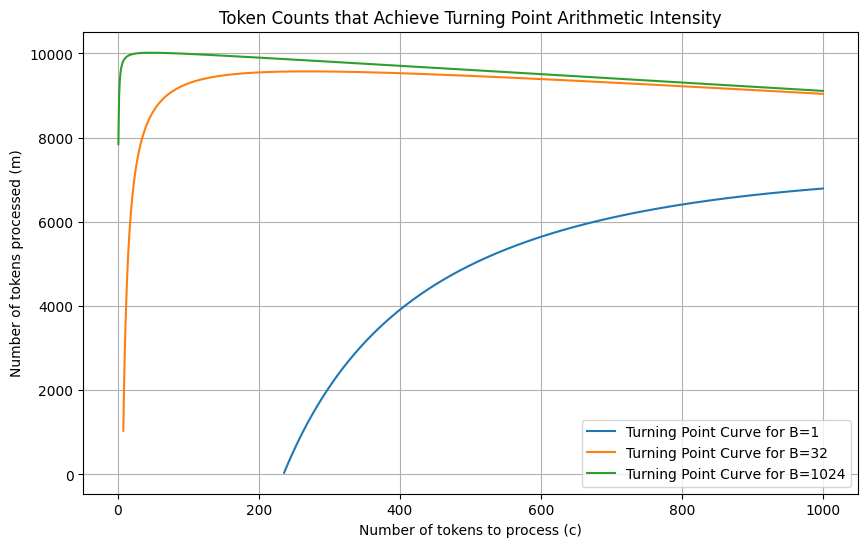

In [25]:
for i in range(3):
    token_counts = analyzer.generate_random_token_counts(num_requests=10, max_tokens=1000)
    analyzer.calculate_arithmetic_intensity(token_counts)

# B [1.1338710947316351e-06 c - 1.1211740456756533e-10 c (c + m)] - 0.00026028960514469453 = 0
# if B = 1, then
# m = (1.1338710947316351e-06 c - 1.1211740456756533e-10 c*c - 0.00026028960514469453) / (1.1211740456756533e-10 c)
#   = (1.1338710947316351e-06 / 1.1211740456756533e-10) - c - (0.00026028960514469453 / 1.1211740456756533e-10 c)
#   = 10113.2477969 - c - (2321580.72289 / c)
# otherwise,
# m = (B 1.1338710947316351e-06 c - B 1.1211740456756533e-10 c*c - 0.00026028960514469453) / B (1.1211740456756533e-10 c)
#   = 10113.2477969 - c - (2321580.72289 / B c)
# So when B = 1, loading weights dominates
# When B >> 1, attention... FLOPS = more sum_c, memory = more sum_c_cm
# here, c(c+m) for both FLOPS and memory is in attention...
analyzer.plot_turning_point_curve()

## 3. Data Transfer Analysis
This section visualizes the breakdown of data transfers between different memory levels.
When using KV offloading, load_KV_cache of fused_attention is affected, as well as store_kv_cache of kv_proj.

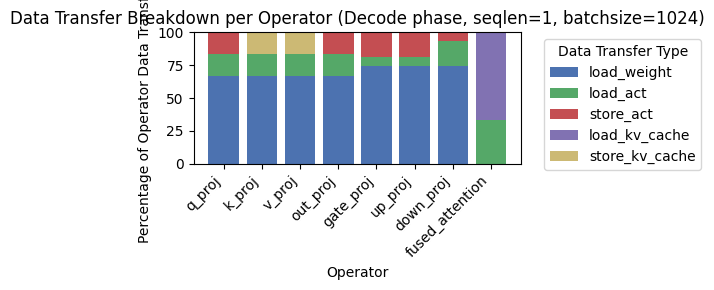

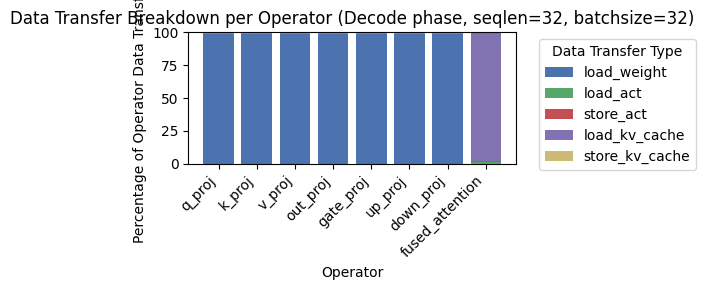

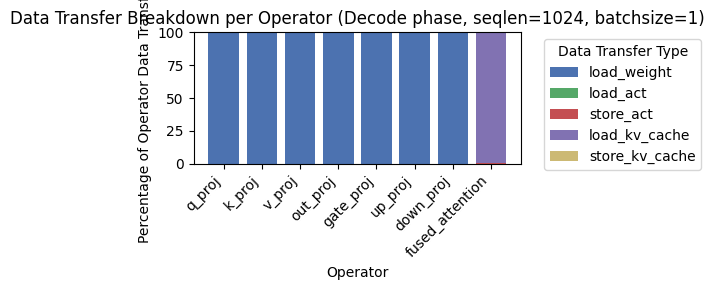

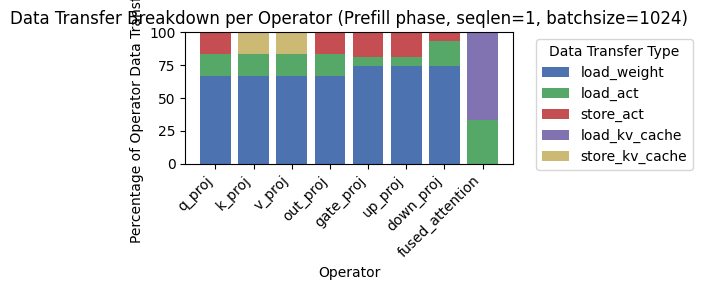

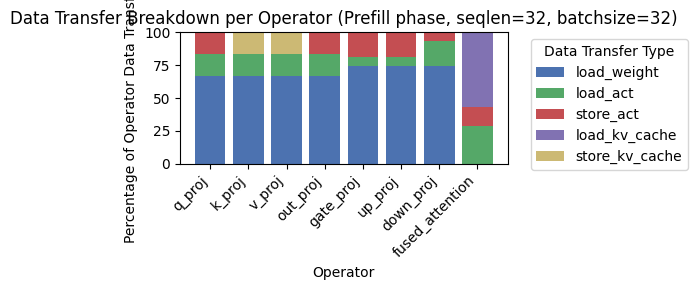

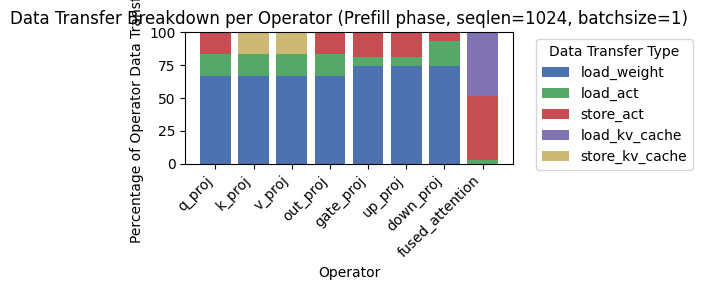

In [33]:
# --- Data Transfer Breakdown Plot ---
import matplotlib.pyplot as plt
import numpy as np

def plot_data_transfer_breakdown(analyzer, seqlen, batchsize, phase="decode"):
    """
    Plot a breakdown of data transfer for each operator in the given phase.
    Each bar is an operator, stacked by load_weight, load_act, store_act, load_kv_cache, store_kv_cache.
    Y-axis is percent of total data transfer for that operator.
    """
    # Get analysis result
    result = analyzer.analyze(seqlen, batchsize, use_flashattention=True)
    phase_data = result[phase]

    # Operators to plot (skip lm_head if you want)
    operators = [op for op in phase_data if op != "lm_head" and '_norm' not in op and '_act' not in op and '_add' not in op]

    # Data transfer keys
    transfer_keys = ["load_weight", "load_act", "store_act", "load_kv_cache", "store_kv_cache"]

    # Prepare data: for each operator, get the transfer amounts
    transfer_matrix = []
    for op in operators:
        op_data = phase_data[op]
        transfers = [op_data[k] for k in transfer_keys]
        total = sum(transfers)
        # Normalize to percent (avoid division by zero)
        if total > 0:
            transfers = [v / total * 100 for v in transfers]
        else:
            transfers = [0 for _ in transfer_keys]
        transfer_matrix.append(transfers)
    transfer_matrix = np.array(transfer_matrix).T  # shape: (5, num_operators)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 3))
    bottom = np.zeros(len(operators))
    colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]
    for i, key in enumerate(transfer_keys):
        ax.bar(operators, transfer_matrix[i], bottom=bottom, label=key, color=colors[i])
        bottom += transfer_matrix[i]

    ax.set_ylabel("Percentage of Operator Data Transfer (%)")
    ax.set_xlabel("Operator")
    ax.set_title(f"Data Transfer Breakdown per Operator ({phase.capitalize()} phase, seqlen={seqlen}, batchsize={batchsize})")
    ax.legend(title="Data Transfer Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
plot_data_transfer_breakdown(analyzer, seqlen=1, batchsize=1024, phase="decode")
plot_data_transfer_breakdown(analyzer, seqlen=32, batchsize=32, phase="decode")
plot_data_transfer_breakdown(analyzer, seqlen=1024, batchsize=1, phase="decode")

plot_data_transfer_breakdown(analyzer, seqlen=1, batchsize=1024, phase="prefill")
plot_data_transfer_breakdown(analyzer, seqlen=32, batchsize=32, phase="prefill")
plot_data_transfer_breakdown(analyzer, seqlen=1024, batchsize=1, phase="prefill")

## 4. 5-Minute Rule
This section applies the 5-minute rule for KV cache. 

The economic feasibility of this trade-off can be evaluated through a break-even analysis inspired by Jim Gray’s five-minute rule [18].

BreakEvenInterval (seconds) = (PagesPerMBofRAM / AccessesPerSecondPerDisk) x (PricePerDiskDrive / PricePerMBofRAM)

PagesPerMBofRAM: Number of pages that fit into one megabyte of RAM. For example, with 4KB pages, there are 256 pages per MB.
AccessesPerSecondPerDisk: The number of random disk accesses per second that a disk can handle.
PricePerDiskDrive: The cost of a disk drive.
PricePerMBofRAM: The cost of one megabyte of RAM.

In Submission 2122, BreakEvenInterval = (PrefillPerMBofSSD / PrefillPerSecPerGPU) x (PricePerGPU / PricePerMBofSSD)

In our case, BreakEvenInterval = t_p x (TotalMiB / S_{MiB}) = 3.8 m

In [55]:
import matplotlib.pyplot as plt
import numpy as np

num_layers = 32

def compute_5_minute_rule(analyzer, seqlen, batchsize, phase="decode"):
    """
    Plot a breakdown of data transfer for each operator in the given phase.
    Each bar is an operator, stacked by load_weight, load_act, store_act, load_kv_cache, store_kv_cache.
    Y-axis is percent of total data transfer for that operator.
    """
    # Get analysis result
    result = analyzer.analyze(seqlen, batchsize, use_flashattention=True)
    phase_data = result[phase]

    # Operators to plot (skip lm_head if you want)
    operators = [op for op in phase_data if op != "lm_head"]

    # Data transfer keys
    transfer_keys = ["load_weight", "load_act", "store_act", "load_kv_cache", "store_kv_cache"]

    KV_size = (phase_data["k_proj"]["store_kv_cache"] + phase_data["v_proj"]["store_kv_cache"]) * num_layers
    KV_time = (phase_data["k_proj"]["inference_time"] + phase_data["v_proj"]["inference_time"]) * num_layers

    print('KV bytes', KV_size)
    print('kv_proj time', KV_time)
    print('KV loading time from DRAM', KV_size / (32*1024*1024*1024))

# --- Example Usage ---
compute_5_minute_rule(analyzer, seqlen=1, batchsize=1, phase="prefill")
compute_5_minute_rule(analyzer, seqlen=1024, batchsize=1, phase="prefill")
compute_5_minute_rule(analyzer, seqlen=1024, batchsize=32, phase="prefill")

KV bytes 524288.0
kv_proj time 0.0013816927485530545
KV loading time from DRAM 1.52587890625e-05
KV bytes 536870912.0
kv_proj time 0.0070481514601025645
KV loading time from DRAM 0.015625
KV bytes 17179869184.0
kv_proj time 0.22554084672328206
KV loading time from DRAM 0.5


seqlen 1 batchsize 1
seqlen 1 batchsize 2
seqlen 1 batchsize 4
seqlen 1 batchsize 8
seqlen 1 batchsize 16
seqlen 1 batchsize 32
seqlen 8 batchsize 1
seqlen 8 batchsize 2
seqlen 8 batchsize 4
seqlen 8 batchsize 8
seqlen 16 batchsize 1
seqlen 16 batchsize 2
seqlen 16 batchsize 4
seqlen 32 batchsize 1
seqlen 32 batchsize 2
seqlen 64 batchsize 1


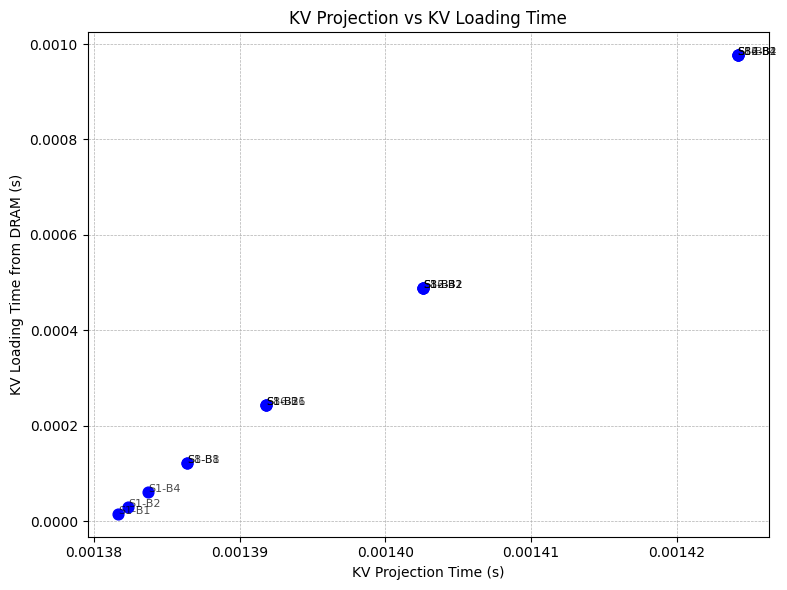

In [60]:
import matplotlib.pyplot as plt
import numpy as np

num_layers = 32  # or get from analyzer/config

seqlen_list = [1, 8, 16, 32, 64, 128, 256, 512, 1024]
batchsize_list = [1, 2, 4, 8, 16, 32]

kv_proj_times = []
kv_load_times = []
labels = []

for seqlen in seqlen_list:
    for batchsize in batchsize_list:
        result = analyzer.analyze(seqlen, batchsize, use_flashattention=True)
        phase_data = result["prefill"]  # or "decode" if you want
        KV_size = (phase_data["k_proj"]["store_kv_cache"] + phase_data["v_proj"]["store_kv_cache"]) * num_layers
        KV_time = (phase_data["k_proj"]["inference_time"] + phase_data["v_proj"]["inference_time"]) * num_layers
        KV_load_time = KV_size / (32*1024*1024*1024)  # 32GB/s bandwidth
        if KV_load_time > KV_time:
            continue
        print('seqlen', seqlen, 'batchsize', batchsize)
        kv_proj_times.append(KV_time)
        kv_load_times.append(KV_load_time)
        labels.append(f"S{seqlen}-B{batchsize}")

plt.figure(figsize=(8, 6))
plt.scatter(kv_proj_times, kv_load_times, c='blue', s=60)
for i, label in enumerate(labels):
    plt.annotate(label, (kv_proj_times[i], kv_load_times[i]), fontsize=8, alpha=0.7)
plt.xlabel("KV Projection Time (s)")
plt.ylabel("KV Loading Time from DRAM (s)")
plt.title("KV Projection vs KV Loading Time")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

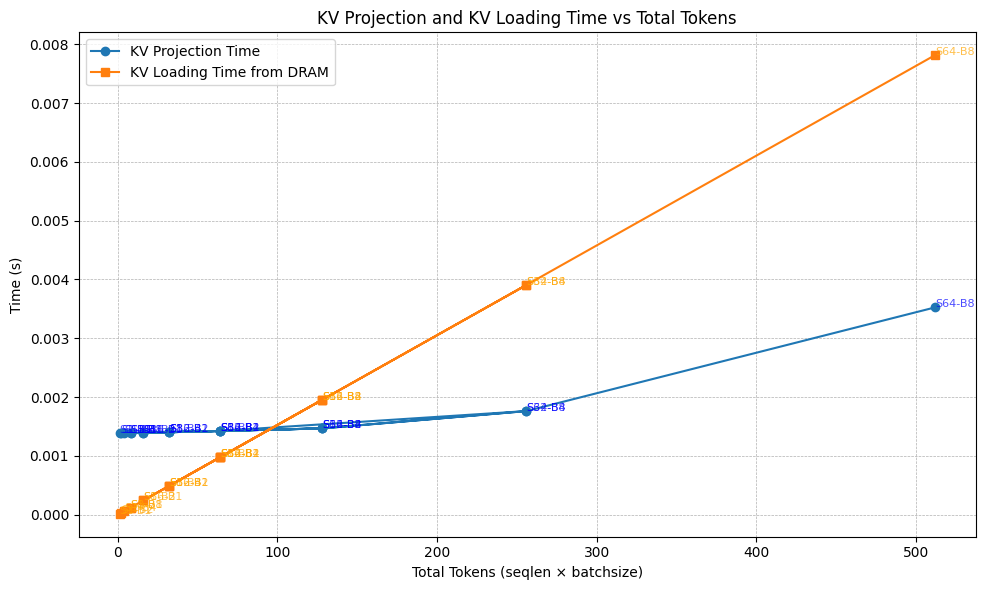

In [62]:
import matplotlib.pyplot as plt
import numpy as np

num_layers = 32  # or get from analyzer/config

seqlen_list = [1, 8, 16, 32, 64]
batchsize_list = [1, 2, 4, 8]

x_tokens = []
kv_proj_times = []
kv_load_times = []
labels = []

for seqlen in seqlen_list:
    for batchsize in batchsize_list:
        result = analyzer.analyze(seqlen, batchsize, use_flashattention=True)
        phase_data = result["prefill"]  # or "decode" if you want
        KV_size = (phase_data["k_proj"]["store_kv_cache"] + phase_data["v_proj"]["store_kv_cache"]) * num_layers
        KV_time = (phase_data["k_proj"]["inference_time"] + phase_data["v_proj"]["inference_time"]) * num_layers
        KV_load_time = KV_size / (32*1024*1024*1024)  # 32GB/s bandwidth
        x = seqlen * batchsize
        x_tokens.append(x)
        kv_proj_times.append(KV_time)
        kv_load_times.append(KV_load_time)
        labels.append(f"S{seqlen}-B{batchsize}")

plt.figure(figsize=(10, 6))
plt.plot(x_tokens, kv_proj_times, 'o-', label="KV Projection Time")
plt.plot(x_tokens, kv_load_times, 's-', label="KV Loading Time from DRAM")
for i, label in enumerate(labels):
    plt.annotate(label, (x_tokens[i], kv_proj_times[i]), fontsize=8, alpha=0.7, color='blue')
    plt.annotate(label, (x_tokens[i], kv_load_times[i]), fontsize=8, alpha=0.7, color='orange')
plt.xlabel("Total Tokens (seqlen × batchsize)")
plt.ylabel("Time (s)")
plt.title("KV Projection and KV Loading Time vs Total Tokens")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

## 99. Memory Consumption Analysis
This section visualizes the memory consumption breakdown for different quantization schemes.

In [42]:
def plot_memory_consumption(seqlen, batchsize):
    fig = plt.figure(figsize=(10, 6))
    bar_width = 0.7
    
    weights = []
    kvs = []
    tmp_acts = []
    categories = []
    xs = []
    x_st = 0
    
    for w, a, kv, quantization in [(16,16,16,"FP16"), (4,16,16,"W4"), (4,16,4,"W4KV4"), (4,4,4,"W4A4")]:
        result = analyzer.analyze(seqlen, batchsize, w, a, kv)
        
        # Get memory consumption for decode phase
        weights.append(result["decode"]["memory_consumption_weight"])
        kvs.append(result["decode"]["memory_consumption_kv_cache"])
        tmp_acts.append(result["decode"]["memory_consumption_tmp_act"])
        xs.append(x_st)
        x_st += 1
        categories.append(f"{quantization}")
        
        # Normalize by FP16 total
        if quantization == "FP16":
            FP16_sum = weights[-1] + kvs[-1] + tmp_acts[-1]
        weights[-1] /= FP16_sum
        kvs[-1] /= FP16_sum
        tmp_acts[-1] /= FP16_sum
    
    plt.bar(xs, weights, bar_width, label='Weight')
    plt.bar(xs, kvs, bar_width, bottom=weights, label='KV cache')
    plt.bar(xs, tmp_acts, bar_width, bottom=np.array(kvs) + np.array(weights), label='Tmp Act')
    
    plt.ylabel('Relative Memory Consumption')
    plt.xticks(xs, categories)
    plt.title(f'Memory Consumption Breakdown (seqlen={seqlen}, batchsize={batchsize})')
    plt.legend()
    plt.tight_layout()
    return fig

# Example usage
fig = plot_memory_consumption(seqlen=1024, batchsize=1)
plt.show()

KeyError: 'memory_consumption_weight'

<Figure size 1000x600 with 0 Axes>